[from this link](https://www.datacamp.com/tutorial/lstm-python-stock-market)

In [15]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [16]:
tesla=pd.read_csv('tesla_all_data_original_dates.csv')

In [17]:
tesla

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Return
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,1.216800,21.679984
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,0.852071,-14.792902
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,0.891204,-10.879634
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,0.865801,-13.419932
...,...,...,...,...,...,...,...,...,...
2714,2021-04-12,228.566666,234.933334,227.363327,233.993332,233.993332,87407100,1.034994,3.499418
2715,2021-04-13,237.566666,254.333328,236.886673,254.106674,254.106674,133958400,1.082577,8.257659
2716,2021-04-14,256.899994,260.263336,242.676666,244.076660,244.076660,147052200,1.023316,2.331589
2717,2021-04-15,247.699997,247.896667,240.436661,246.283340,246.283340,83546700,0.952484,-4.751598


In [18]:
len(tesla)

2719

In [19]:
df=tesla[['Date','Adj Close']]

In [20]:
data=df['Adj Close'].values

In [21]:
# Separate train and test data
train_length = int(len(data) * 0.95)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  2583
Shape of Train and Test data:  (2583,) (136,)


In [22]:
train_data

array([  1.59266698,   1.58866704,   1.46399999, ..., 140.3999939 ,
       139.69000244, 143.00332642])

In [23]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (2583, 1) (136, 1)


In [24]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()

In [25]:
train_data

array([[  1.59266698],
       [  1.58866704],
       [  1.46399999],
       ...,
       [140.3999939 ],
       [139.69000244],
       [143.00332642]])

In [26]:
# Train the Scaler with training data and smooth data

len_train=len(train_data)
smoothing_window_size = len(train_data)//4

for i in range(0,len_train,smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])

# You normalize the last bit of remaining data
# scaler.fit(train_data[i+smoothing_window_size:,:])
# train_data[i+smoothing_window_size:,:] = scaler.transform(train_data[i+smoothing_window_size:,:])

In [27]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
scaler.fit(test_data)
test_data = scaler.transform(test_data).reshape(-1)

In [28]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len_train):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [29]:
train_data.size

2583

In [30]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01414


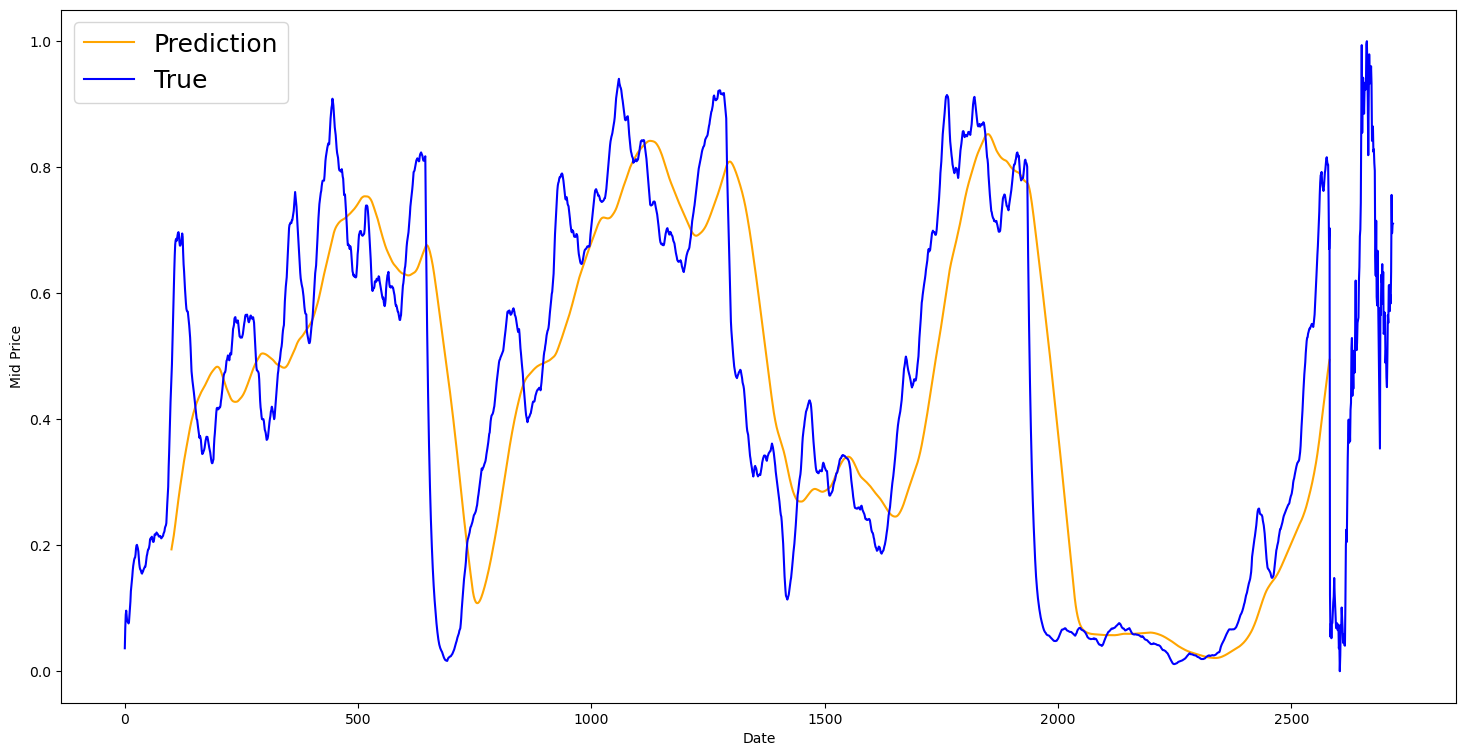

In [31]:
plt.figure(figsize = (18,9))

plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [32]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00012


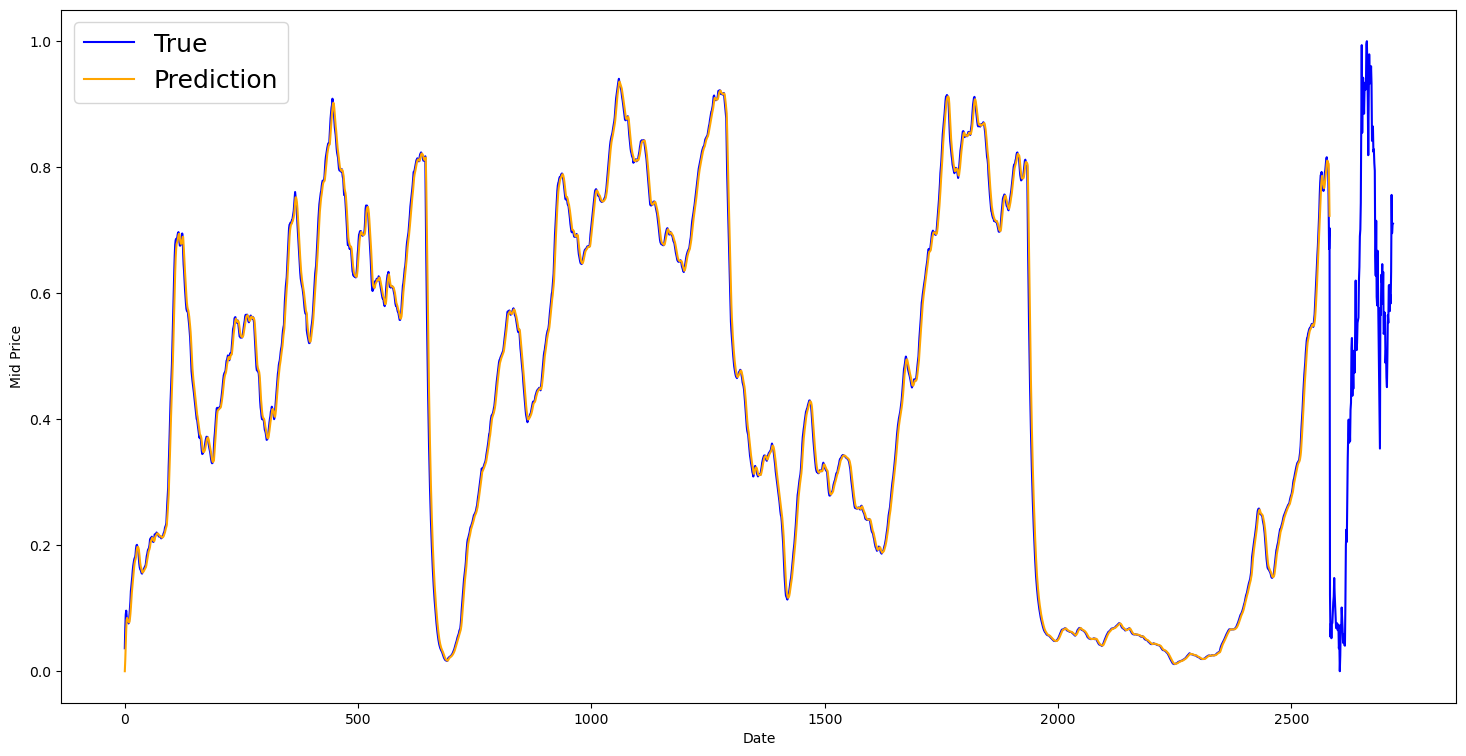

In [33]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [34]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.03642507 0.7142217  0.7548126  0.33956113 0.05952667]

	Output: [0.089779   0.73918676 0.7655093  0.33852026 0.05457208]


Unrolled index 1
	Inputs:  [0.06893749 0.73356944 0.76044875 0.33868834 0.05797462]

	Output: [0.08789437 0.73923093 0.7655093  0.33868834 0.05797462]


Unrolled index 2
	Inputs:  [0.089779   0.73923093 0.7655093  0.33852026 0.05658686]

	Output: [0.07866857 0.7304432  0.7900139  0.33636963 0.0522486 ]


Unrolled index 3
	Inputs:  [0.09610954 0.7389233  0.7742123  0.3375112  0.05457208]

	Output: [0.09610954 0.7304432  0.800395   0.33290815 0.0522486 ]


Unrolled index 4
	Inputs:  [0.08789437 0.73918676 0.78341985 0.33739454 0.05372131]

	Output: [0.07866857 0.73726267 0.800395   0.33290815 0.05269359]


In [2]:
import tensorflow as tf 

In [4]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

#tf.reset_default_graph() # This is important in case you run this multiple times

In [7]:
# Input data.

# Input data.
train_inputs, train_outputs = [],[]

for ui in range(num_unrollings):
    train_inputs.append(tf.ones([batch_size, D], dtype=tf.float32, name='train_inputs_%d'%ui))
    train_outputs.append(tf.ones([batch_size, 1], dtype=tf.float32, name='train_outputs_%d'%ui))


In [15]:
class CustomLSTM(tf.keras.layers.LSTM):
    def __init__(self, units, **kwargs):
        super(CustomLSTM, self).__init__(units, **kwargs)

    @property
    def state_size(self):
        return [self.units, self.units]

lstm_cells = [
    CustomLSTM(units=num_nodes[li],
               kernel_initializer=tf.keras.initializers.glorot_uniform(),
               dropout=dropout)
    for li in range(n_layers)]

drop_multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)
multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

w = tf.Variable(tf.keras.initializers.glorot_uniform()([num_nodes[-1], 1]))
b = tf.Variable(tf.random.uniform([1],-0.1,0.1))

In [19]:
import tensorflow as tf

lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li],
                             kernel_initializer=tf.keras.initializers.glorot_uniform(),
                             dropout=dropout)
    for li in range(n_layers)]

multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

initial_state = multi_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

# Do several tensor transformations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    multi_cell, all_inputs, initial_state=initial_state,
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

w = tf.Variable(tf.keras.initializers.glorot_uniform()([num_nodes[-1], 1]))
b = tf.Variable(tf.random.uniform([1],-0.1,0.1))

all_outputs = tf.keras.backend.bias_add(tf.keras.backend.dot(all_lstm_outputs, w), b)

split_outputs = tf.split(all_outputs, num_or_size_splits=num_unrollings, axis=0)

In [21]:
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li],
                             kernel_initializer=tf.keras.initializers.glorot_uniform(),
                             dropout=dropout)
    for li in range(n_layers)]

multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

c, h = [], []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))

initial_state = tuple([(c[li], h[li]) for li in range(n_layers)])

# Do several tensor transformations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    multi_cell, all_inputs, initial_state=initial_state,
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

w = tf.Variable(tf.keras.initializers.glorot_uniform()([num_nodes[-1], 1]))
b = tf.Variable(tf.random.uniform([1],-0.1,0.1))

all_outputs = tf.keras.backend.bias_add(tf.keras.backend.dot(all_lstm_outputs, w), b)

split_outputs = tf.split(all_outputs, num_or_size_splits=num_unrollings, axis=0)

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

TypeError: The two structures don't have the same nested structure.

First structure: type=list str=[TensorSpec(shape=(), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.int32, name=None), ([TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)],), ((TensorSpec(shape=(500, 200), dtype=tf.float32, name=None), TensorSpec(shape=(500, 200), dtype=tf.float32, name=None)), (TensorSpec(shape=(500, 200), dtype=tf.float32, name=None), TensorSpec(shape=(500, 200), dtype=tf.float32, name=None)), (TensorSpec(shape=(500, 150), dtype=tf.float32, name=None), TensorSpec(shape=(500, 150), dtype=tf.float32, name=None))))]

Second structure: type=list str=[1, (<tf.Tensor: shape=(), dtype=int32, numpy=1>, ([<tf.Tensor: shape=(500, 150), dtype=float32, numpy=
array([[ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       ...,
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92886213e-05,  1.15455005e-04, -2.48290686e-04, ...,
         1.61012824e-04,  1.80724328e-05, -4.12665802e-04],
       [ 3.92886213e-05,  1.15455005e-04, -2.48290686e-04, ...,
         1.61012824e-04,  1.80724328e-05, -4.12665802e-04]], dtype=float32)>, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],), (ListWrapper([<tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       ...,
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596]], dtype=float32)>, <tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       ...,
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591]], dtype=float32)>]), ListWrapper([<tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348],
       [-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348],
       [-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348],
       ...,
       [-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348],
       [-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348],
       [-0.00026324,  0.00232376, -0.00237046, ..., -0.00051646,
         0.00286912, -0.00180348]], dtype=float32)>, <tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781],
       [-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781],
       [-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781],
       ...,
       [-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781],
       [-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781],
       [-0.00052649,  0.00460766, -0.00473335, ..., -0.00102941,
         0.00573405, -0.00360781]], dtype=float32)>]), ListWrapper([<tf.Tensor: shape=(500, 150), dtype=float32, numpy=
array([[ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       ...,
       [ 3.92889706e-05,  1.15455143e-04, -2.48290773e-04, ...,
         1.61012911e-04,  1.80723473e-05, -4.12665715e-04],
       [ 3.92886213e-05,  1.15455005e-04, -2.48290686e-04, ...,
         1.61012824e-04,  1.80724328e-05, -4.12665802e-04],
       [ 3.92886213e-05,  1.15455005e-04, -2.48290686e-04, ...,
         1.61012824e-04,  1.80724328e-05, -4.12665802e-04]], dtype=float32)>, <tf.Tensor: shape=(500, 150), dtype=float32, numpy=
array([[ 7.8515004e-05,  2.3056315e-04, -4.9707730e-04, ...,
         3.2190749e-04,  3.6143167e-05, -8.2621892e-04],
       [ 7.8515004e-05,  2.3056315e-04, -4.9707730e-04, ...,
         3.2190749e-04,  3.6143167e-05, -8.2621892e-04],
       [ 7.8515004e-05,  2.3056315e-04, -4.9707730e-04, ...,
         3.2190749e-04,  3.6143167e-05, -8.2621892e-04],
       ...,
       [ 7.8515004e-05,  2.3056315e-04, -4.9707730e-04, ...,
         3.2190749e-04,  3.6143167e-05, -8.2621892e-04],
       [ 7.8514306e-05,  2.3056287e-04, -4.9707713e-04, ...,
         3.2190731e-04,  3.6143338e-05, -8.2621904e-04],
       [ 7.8514306e-05,  2.3056287e-04, -4.9707713e-04, ...,
         3.2190731e-04,  3.6143338e-05, -8.2621904e-04]], dtype=float32)>])))]

More specifically: The two namedtuples don't have the same sequence type. First structure type=tuple str=(TensorSpec(shape=(500, 200), dtype=tf.float32, name=None), TensorSpec(shape=(500, 200), dtype=tf.float32, name=None)) has type tuple, while second structure type=ListWrapper str=ListWrapper([<tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       ...,
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596],
       [-0.01961068,  0.0131405 ,  0.00314627, ..., -0.00964903,
         0.01563755,  0.00480596]], dtype=float32)>, <tf.Tensor: shape=(500, 200), dtype=float32, numpy=
array([[-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       ...,
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591],
       [-0.03818845,  0.02543199,  0.00616606, ..., -0.01993554,
         0.0310219 ,  0.00929591]], dtype=float32)>]) has type ListWrapper
Entire first structure:
[., (., ([., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., .],), ((., .), (., .), (., .)))]
Entire second structure:
[., (., ([., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., .],), (ListWrapper([., .]), ListWrapper([., .]), ListWrapper([., .])))]